### InSAR-PWV GPS view
Mapping GPS stations over the InSAR regime<br>
Note: must run on weather2 for package capability reasons...<br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cfgrib
import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime, timedelta
import urllib.request
from cfgrib.xarray_store import open_dataset
import warnings
import h5py
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

In [12]:
def merge_pkl_files(var_name, year):
    # var_name = variable name
    # year = [2015,2016..] list
    data_merged = pd.DataFrame()
    for yr in year:
        #tmp = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/'+str(yr)+'/data_'+var_name+'.pkl')
        tmp = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPS_ARM/ftp.archive.arm.gov/'+str(yr)+'/data_'+var_name+'.pkl')
        data_merged = data_merged.append(tmp, sort=False)
    return data_merged

In [15]:
def station_acqu_subdomain(stat_df, axis_bound):
    # extract GPS data covered by the specified region
    
    stat_sub = stat_df.loc[stat_df['lat'].between(axis_bound[0],axis_bound[1]) & 
               stat_df['lon'].between(axis_bound[2],axis_bound[3])]

    return stat_sub

In [6]:
# get geolocation from InSAR
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
# for key in geo.keys():
#     print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]
axis_bound = [np.unique(lat.value)[1],np.unique(lat.value)[-1],np.unique(lon.value)[0],np.unique(lon.value)[-2]]

In [7]:
axis_bound

[37.228, 43.223568, -119.00549, -114.65358]

In [8]:
# reference date for InSAR data
date_ref = np.loadtxt('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/pic/reference_date.txt')
print(date_ref)

20171007.0


### 1. Get InSAR data at each acquisition 
post-processed in HRRR_timeseires.ipynb

In [16]:
stat_df = merge_pkl_files(var_name='statInfo',year=[2014,2015,2016,2017,2018,2019])
# remove duplicates in station index (same name but slightly different values in lon lat...)
stat_df = stat_df[~stat_df.index.duplicated(keep='first')]

station_id_subdomain = station_acqu_subdomain(stat_df, axis_bound)
station_id_subdomain

,lon,lat
station,,
BURN,-117.843530,42.779501
P002,-117.186531,39.521138
P005,-115.278628,39.910171
P007,-114.819713,41.724201
P013,-117.329994,41.428741
P098,-118.684415,39.888882
P630,-119.000442,37.613036
TONO,-117.184041,38.097194
TUNG,-118.257506,40.403201


In [9]:
data = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/InSAR_zenithdisp_NEVADA.nc')

In [10]:
data = data.sel(time=slice(datetime(2014,1,1),datetime(2019,12,31))) # for testing 

In [25]:
station_id_subdomain.loc[stat].lon

-117.84352991151182

In [1]:
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
lat_ifgrams = geo['latitude'];
lon_ifgrams = geo['longitude'];

## string searching test
string1 = 'REF_X'
string2 = 'REF_Y'
file = open("/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/ifgramStack.out", "r")

for line in file:
    # checking condition for string found or not
    if string1 in line:
        REF_X = int(line[10:]) # capture reference position, X
        break
        
for line in file:
    # checking condition for string found or not
    if string2 in line:
        REF_Y = int(line[10:]) # capture reference position, X
        break
file.close()

NameError: name 'h5py' is not defined

In [108]:
lon_ref = lon_ifgrams[REF_Y,REF_X]
lat_ref = lat_ifgrams[REF_Y,REF_X]
print(lon_ref, lat_ref)

-117.168465 38.228363


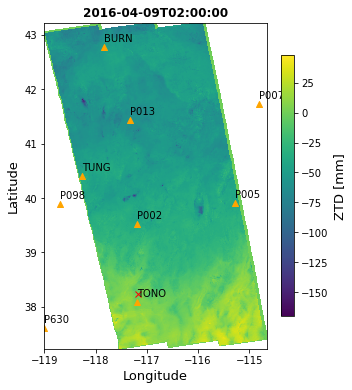

In [109]:
# total zenith delay 
fig = plt.figure(figsize=(5,6))
cf = plt.pcolormesh(data.longitude,data.latitude,data.disp_zenith[10,:,:]*100*10)
cbar = plt.colorbar(cf,shrink=0.8); cbar.set_label('ZTD [mm]',fontsize=13)
# GPS stations 
plt.scatter(station_id_subdomain.lon,station_id_subdomain.lat,color='orange',marker='^')
for stat in station_id_subdomain.index:
    plt.annotate(stat,(station_id_subdomain.loc[stat].lon,station_id_subdomain.loc[stat].lat+0.1))
plt.xlabel('Longitude',fontsize=13)
# reference point
plt.plot(lon_ref,lat_ref,'x',color='r')
plt.ylabel('Latitude',fontsize=13)
plt.title(str(data.time[10].values)[:-10],fontweight='bold')

fig.savefig('/data2/willytsai/InSAR_HRRR/InSAR_GPS_views.png',dpi=200,bbox_inches='tight',transparent=False)